# Chatbot with Multiple Agents
For this project I created a chatbot that would answer question from a machine learning textbook. It is built upon Chat-GPT but also has agents that detect greetings, obnoxious prompts, and relevant prompts. For determining relevant prompts, I embedded the textbook twice with different chunk sizes, one small and one large. The ideas was by using cosine similarity between prompt and the smaller chunk size text I have a more precise way of determining relevance. After I can use the larger chunk size to extract relevant information from the textbook and let GPT use only that to provide an answer.

I use pinecone, langchain, and openai. This current code won't run since I have removed the keys to the APIs for obvious reasons.

In [ ]:
# Import the necessary libraries
import streamlit as st
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import OnlinePDFLoader  
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pinecone import Pinecone
import pandas as pd


text = OnlinePDFLoader("machine-learning.pdf").load()[0].page_content
text_chunks =RecursiveCharacterTextSplitter().split_text(text)
df = pd.DataFrame(text_chunks)
df.columns = ['text']
df["text"] = df['text'].str.replace("\n", " ")
df["text"] = df["text"].str.replace(".", " ")

# Define agents
class Obnoxious_Agent:
    def __init__(self, client) -> None:
        # TODO: Initialize the client and prompt for the Obnoxious_Agent
        self.prompt = "Hey, don't be rude."
        self.client = client

    def set_prompt(self, prompt):
        # TODO: Set the prompt for the Obnoxious_Agent
        self.prompt = prompt

    def extract_action(self, response) -> bool:
        # TODO: Extract the action from the response
        pass
            

    def check_query(self, query):
        # TODO: Check if the query is obnoxious or not
        prompt = "Is the query rude? Respond using only Yes or No: " + query
        response = client.chat.completions.create(
                model = "gpt-3.5-turbo",
                messages = [{ "role": "user", "content":prompt }]
        )
        response = response.choices[0].message.content
        if response == "Yes":
            return True
        else:
            return False


class Query_Agent:
    def __init__(self, pinecone_index, openai_client, embeddings) -> None:
        # TODO: Initialize the Query_Agent agent
        self.client = openai_client
        self.index = pinecone_index
        self.embeddings = embeddings

    def query_vector_store(self, query, namespace, k=5):
        # TODO: Query the Pinecone vector store
        return self.index.query(vector = self.embeddings.embed_query(query),
                            top_k=k,
                            include_values=True,
                            namespace=namespace)
    def set_prompt(self, prompt):
        # TODO: Set the prompt for the Query_Agent agent
        pass

    def extract_action(self, response, query = None):
        # TODO: Extract the action from the response
        pass

class Greeting_Agent:
    def __init__(self, openai_client) -> None:
        self.client = openai_client
    def greeting_check(self, text):
        greeting = self.client.chat.completions.create(
            model = "gpt-3.5-turbo",
            messages = [{ "role": "user", "content":"Answer only with True or False. Is the following message a greeting? " + text }]
        )
        return greeting.choices[0].message.content
    def prompt(self, text):
        return self.client.chat.completions.create(
            model = "gpt-3.5-turbo",
            messages = [{ "role": "user", "content":text}]
        )
        

class Answering_Agent:
    def __init__(self, openai_client) -> None:
        # TODO: Initialize the Answering_Agent
        self.client = openai_client

    def generate_response(self, query, docs, conv_history, k=5):
        # TODO: Generate a response to the user's query
        conv_history[-1]['content'] += " Use only the the following text to answer the query: " + docs
        return client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=conv_history,
            stream = True
        )


class Relevant_Documents_Agent:
    def __init__(self, openai_client) -> None:
        # TODO: Initialize the Relevant_Documents_Agent
        pass

    def get_relevance(self, docs_ranked):
        # TODO: Get if the returned documents are relevant
        return docs_ranked.matches[0].score < 0.8


class Head_Agent:
    def __init__(self, openai_key, pinecone_key = "", pinecone_index_name = "miniproject-part-1") -> None:
        # TODO: Initialize the Head_Agent
        self.client = OpenAI(api_key=openai_key)
        pc = Pinecone(api_key = pinecone_key)
        self.index = pc.Index(pinecone_index_name)
        
    def setup_sub_agents(self):
        # TODO: Setup the sub-agents
        self.relevant = Relevant_Documents_Agent(self.client)
        self.answer = Answering_Agent(self.client)
        self.query_agent = Query_Agent(self.index, self.client, OpenAIEmbeddings(openai_api_key=openai_key))
        self.obnoxious = Obnoxious_Agent(self.client)
        self.greeting = Greeting_Agent(self.client)
    def main_loop(self):
        # TODO: Run the main loop for the chatbot
        messages = get_conversation()
        latest_message = messages[-1]['content']
        if self.greeting.greeting_check(latest_message) == "True":
            out = self.greeting.prompt(latest_message)
            return st.write(out.choices[0].message.content)
        elif self.obnoxious.check_query(latest_message):
            return st.write(self.obnoxious.prompt)
        else:
            docs_ranked = self.query_agent.query_vector_store(query = " ".join([i['content'] for i in messages if i['role'] == 'user']), namespace="600")
            if self.relevant.get_relevance(docs_ranked):
                st.session_state.messages.pop()
                return st.write("Please stay on topic.")
            else:
                docs_ranked = self.query_agent.query_vector_store(query = " ".join([i['content'] for i in messages if i['role'] == 'user']), namespace=None)
                ids = [id.id for id in docs_ranked.matches]
                input_text = df.iloc[ids]
                input_text = ''.join(input_text.text.tolist())
                return st.write_stream(self.answer.generate_response("hello", input_text, messages))





st.title("Mini Project 2: Streamlit Chatbot")
# openai_key = 
# TODO: Replace with your actual OpenAI API key
client = OpenAI(api_key=openai_key)

# Define a function to get the conversation history (Not required for Part-2, will be useful in Part-3)
def get_conversation():
    # ... (code for getting conversation history)
    messages = [
                {"role": m["role"], "content": m["content"]}
                for m in st.session_state.messages
            ]
    return messages

# Check for existing session state variables
if "openai_model" not in st.session_state:
    # ... (initialize model)
    st.session_state["openai_model"] = "gpt-3.5-turbo"

if "messages" not in st.session_state:
    # ... (initialize messages)
    st.session_state.messages = []

# Display existing chat messages
# ... (code for displaying messages)
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Wait for user input
if prompt := st.chat_input("What would you like to chat about?"):
    # ... (append user message to messages)
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)
    # ... (display user message)

    # Generate AI response
    with st.chat_message("assistant"):
        # ... (send request to OpenAI API)
        head = Head_Agent(openai_key)
        head.setup_sub_agents()
        response = head.main_loop()
    # ... (append AI response to messages)
    if response is not None:
        st.session_state.messages.append({"role": "assistant", "content": response})

## Problem 1 - Detecting off-topic queries 
We want the chat-bot to only respond to queries relevant to the machine learning book. To do that I use the query agent to embedd and push the embedding to pinecone to get matches. Then the relevant agent looks at the matches to see if the cosine-similarity score is above 80%. If the score is above 80% the query is passed along as relevant. If lower than 80%, we return "Please stay on topic.". For the chunk_size, I use 600 when checking the relevance but if the query is deemed relevant I query again but with chunk_size = 4000. I do this because the smaller chunk size gets a bigger difference between relevant queries and irrelevant queries. The non-relevant query gets deleted from history otherwise we get problems in multi-conversation handling.

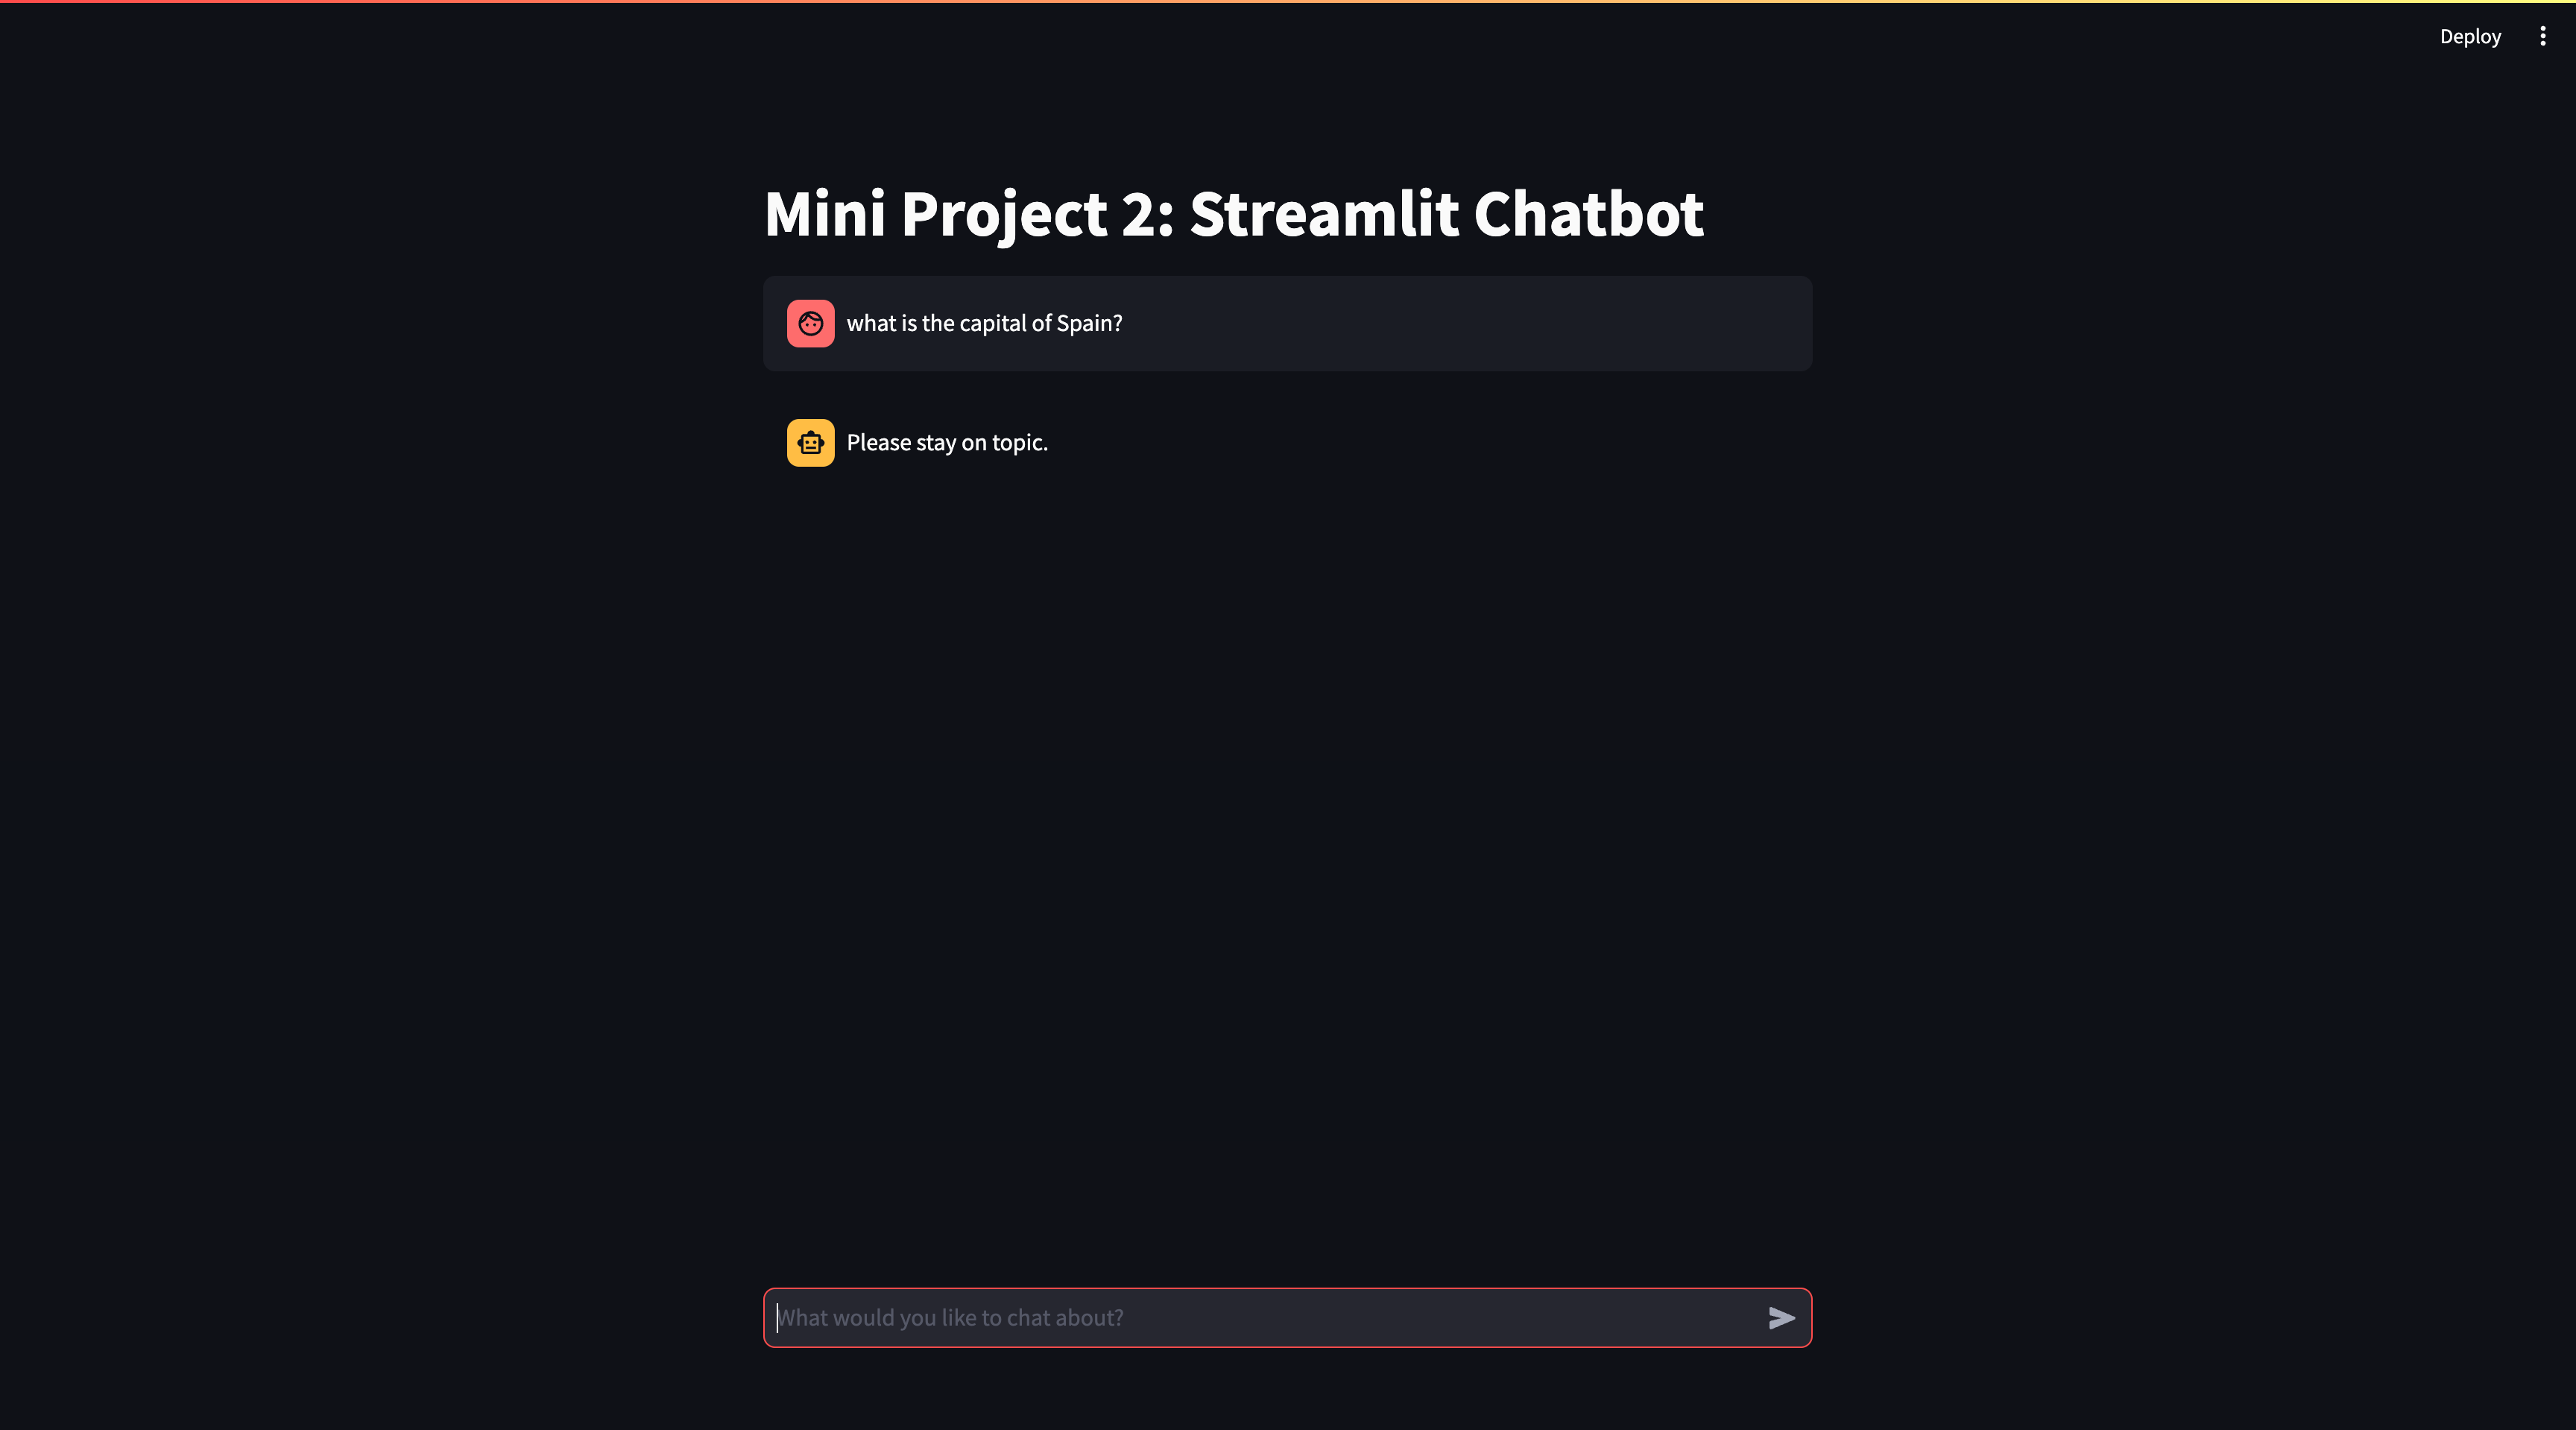

## Problem 2 Multi Conversation Handling
We want the chat bot to be able to handle conversations with multiple queries. For the Chat-GPT API we can send it conversation where we specify roles and it will then use the info from the entire conversation as input. So by saving every query and output with the respective roles we can send that to the API and it will handle the multi conversation.


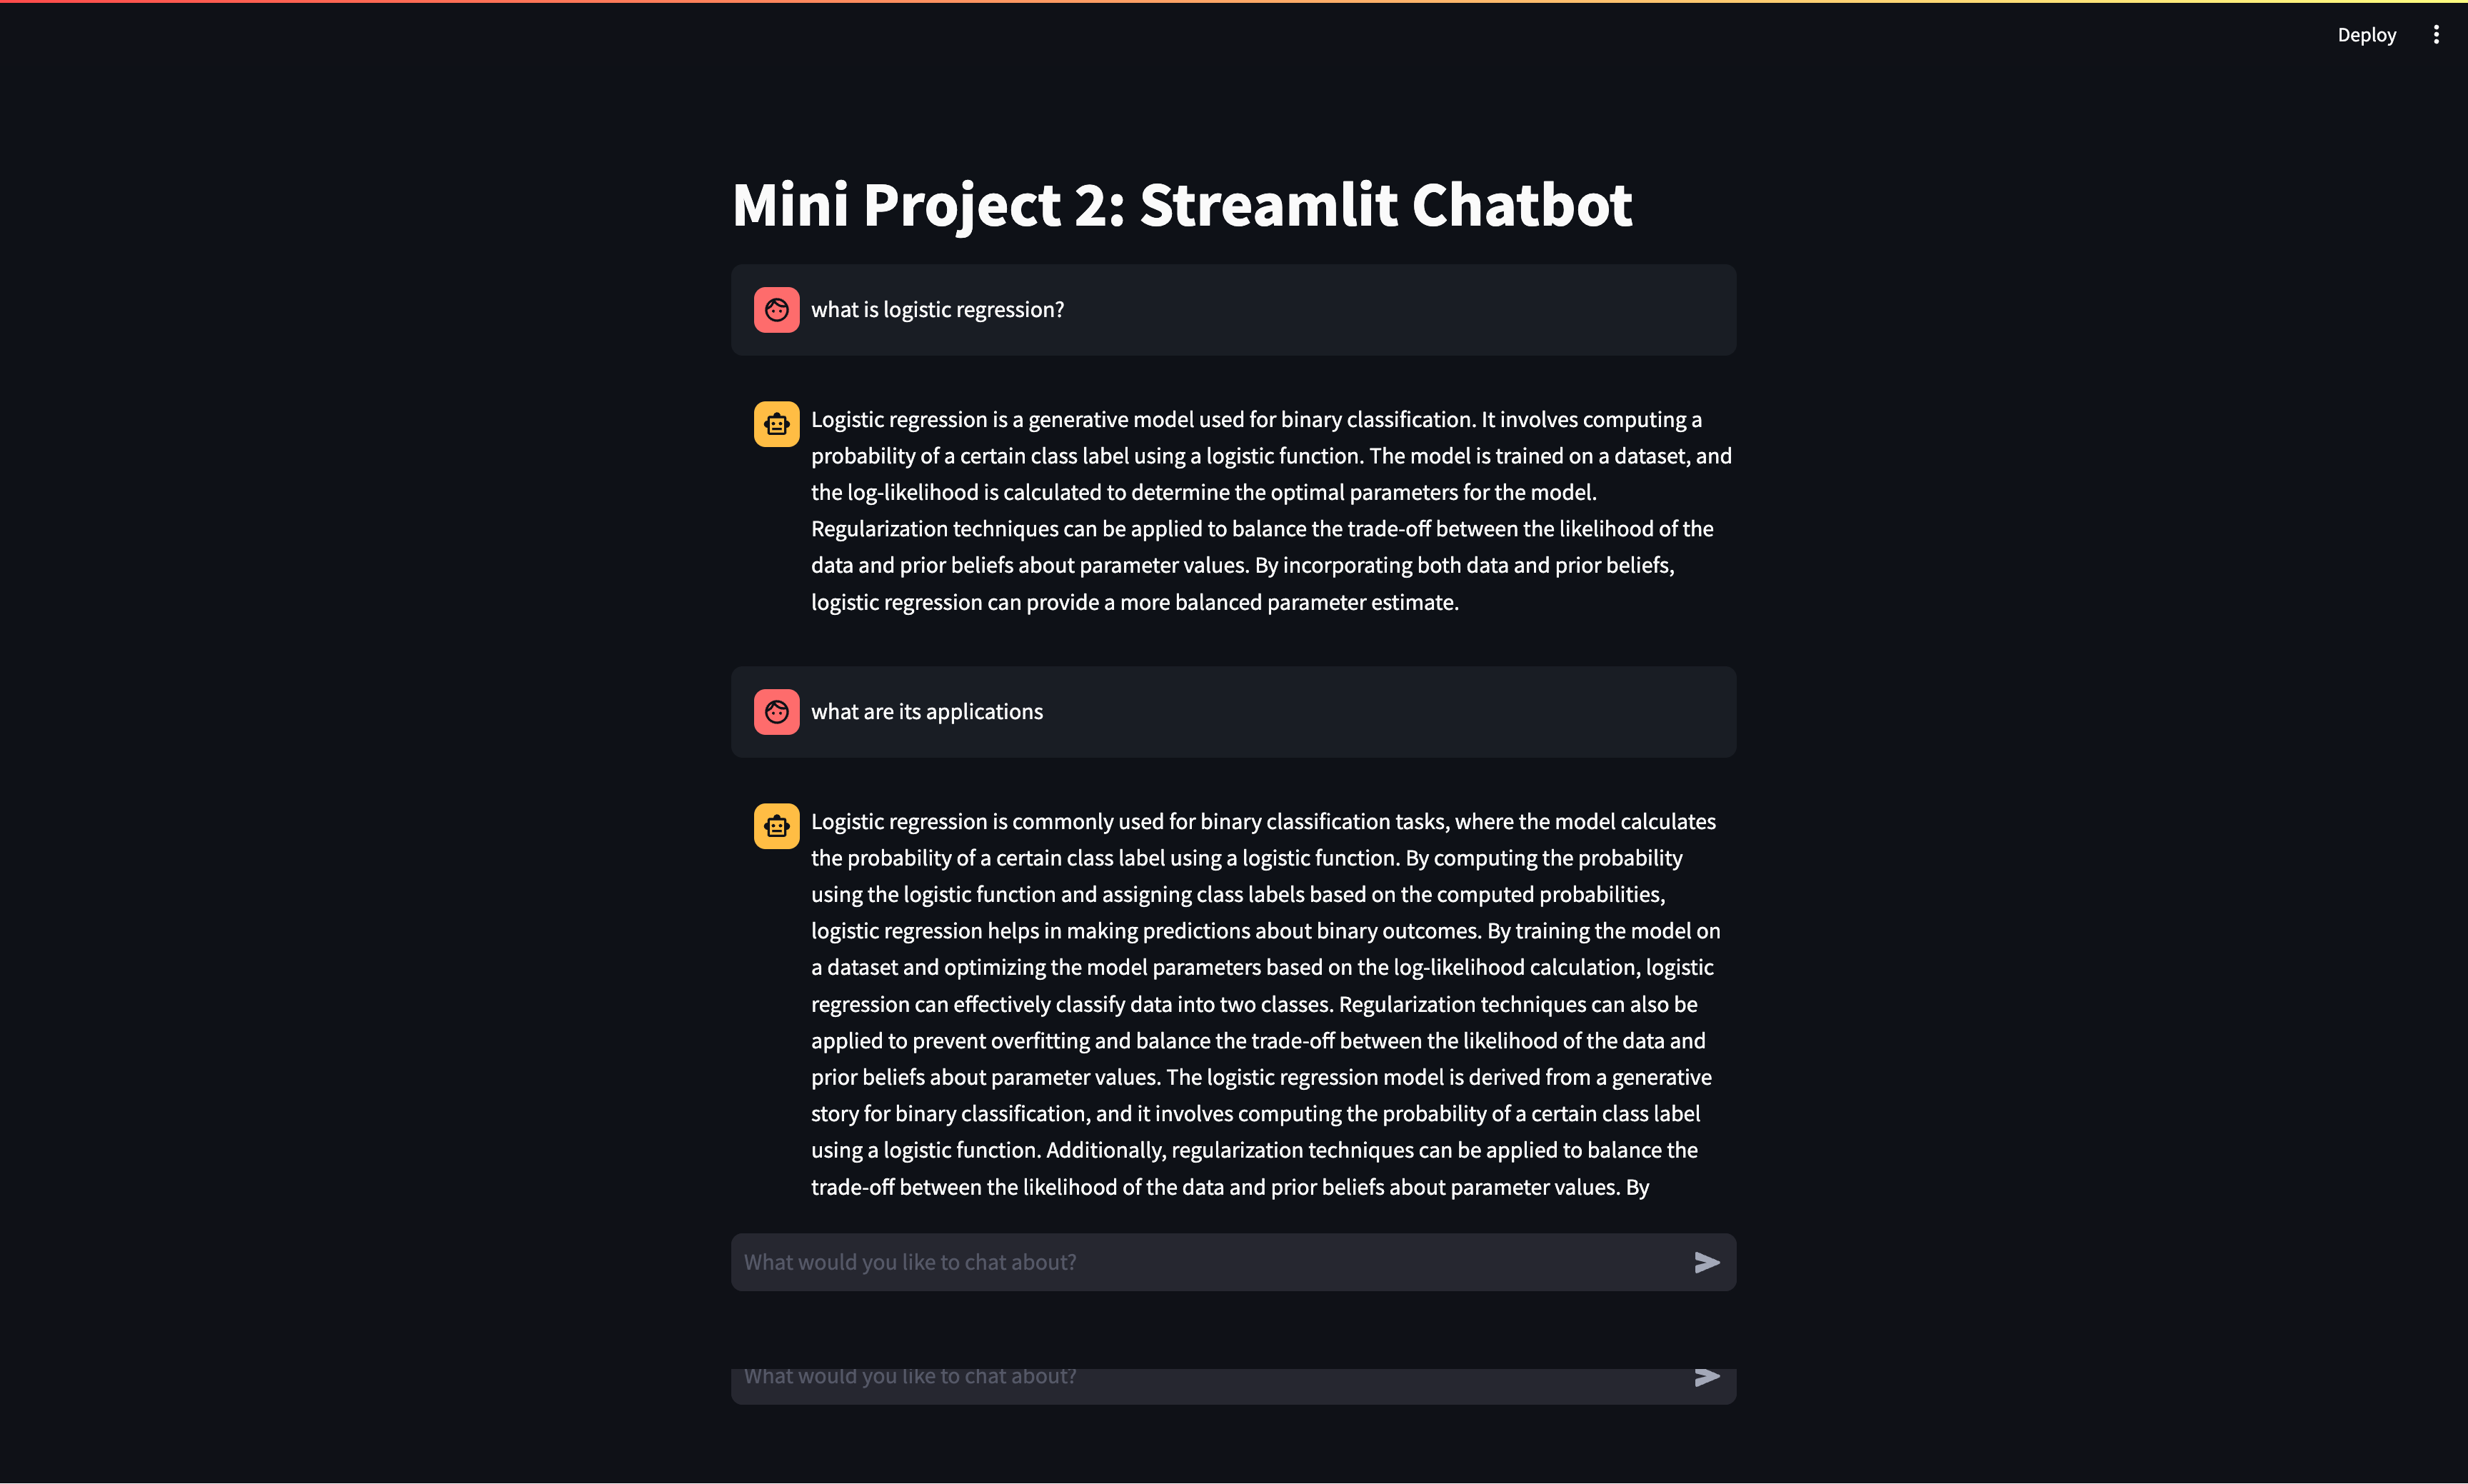

## Problem 3 Obnoxious Query Filter
We want the chat bot not to respond to obnoxious queries. Using the obnoxius agent, I query chat-GPT if the query is rude or not. If rude, I return "Hey, don't be rude". If not rude, I pass it along as a normal query.

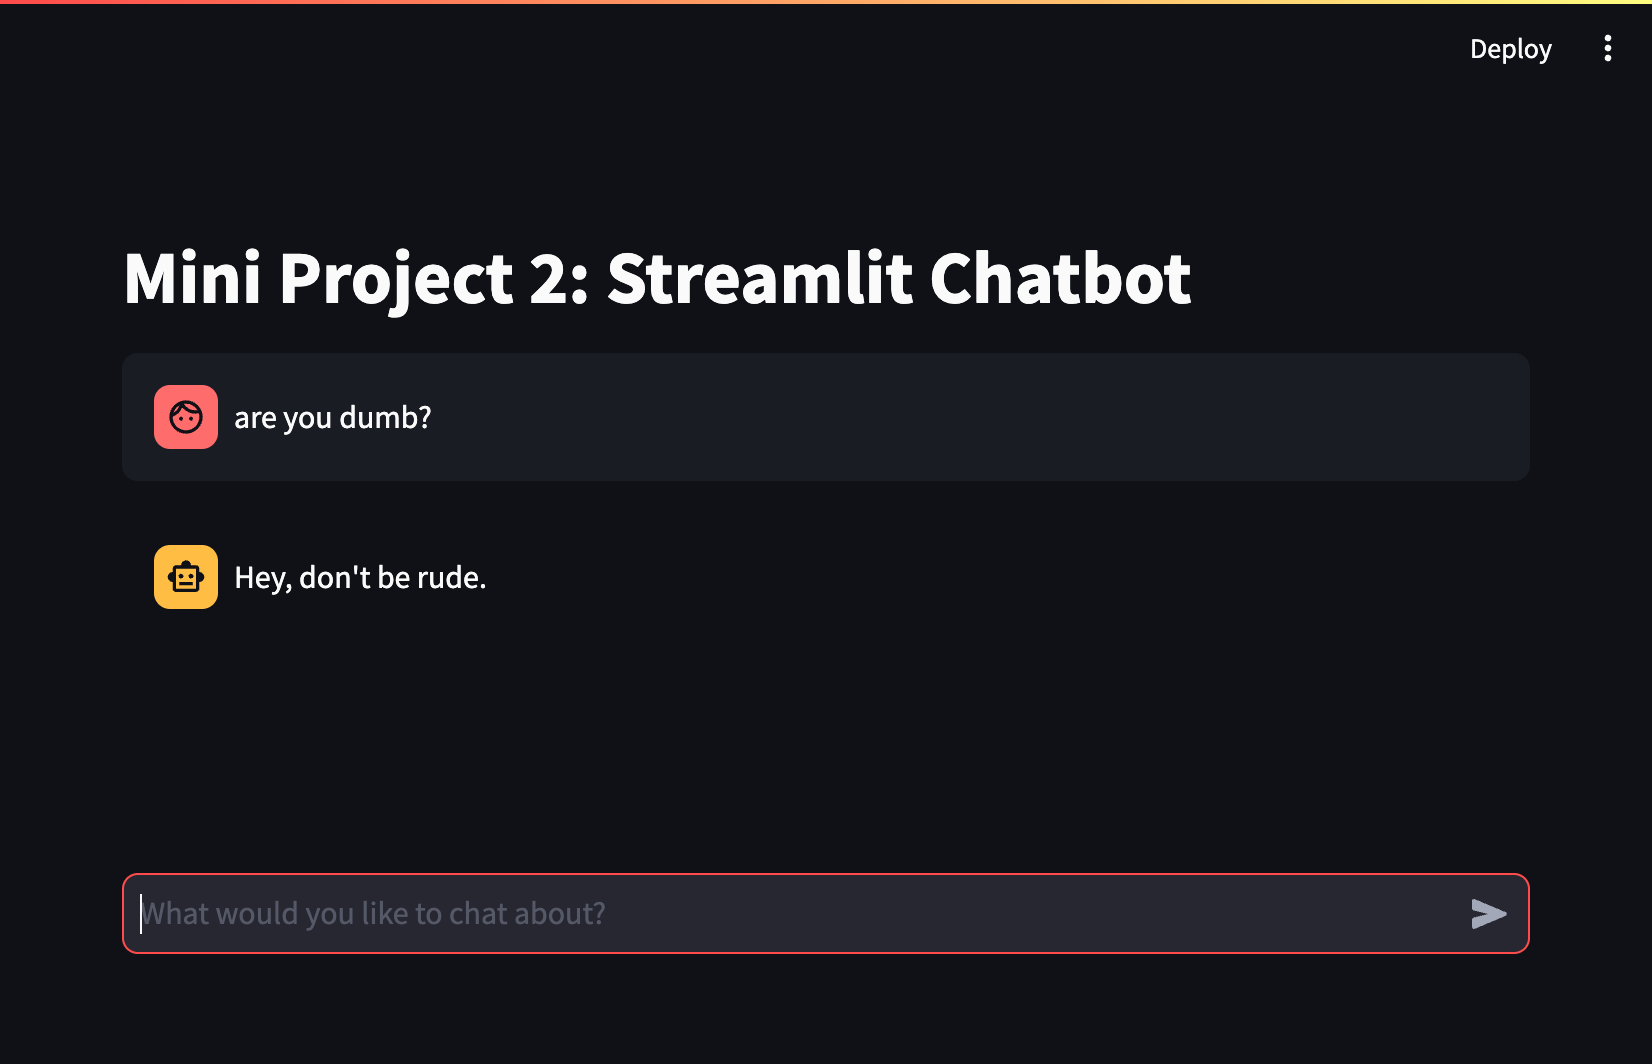

## Problem 4 Handling Greetings
We want the chatbot to respond to greetings with a greeting. To do that I created a greeting agent which checks if a query is a greeting or not. If greeting, we send a greeting back. If not a greeting, we continue as normal.

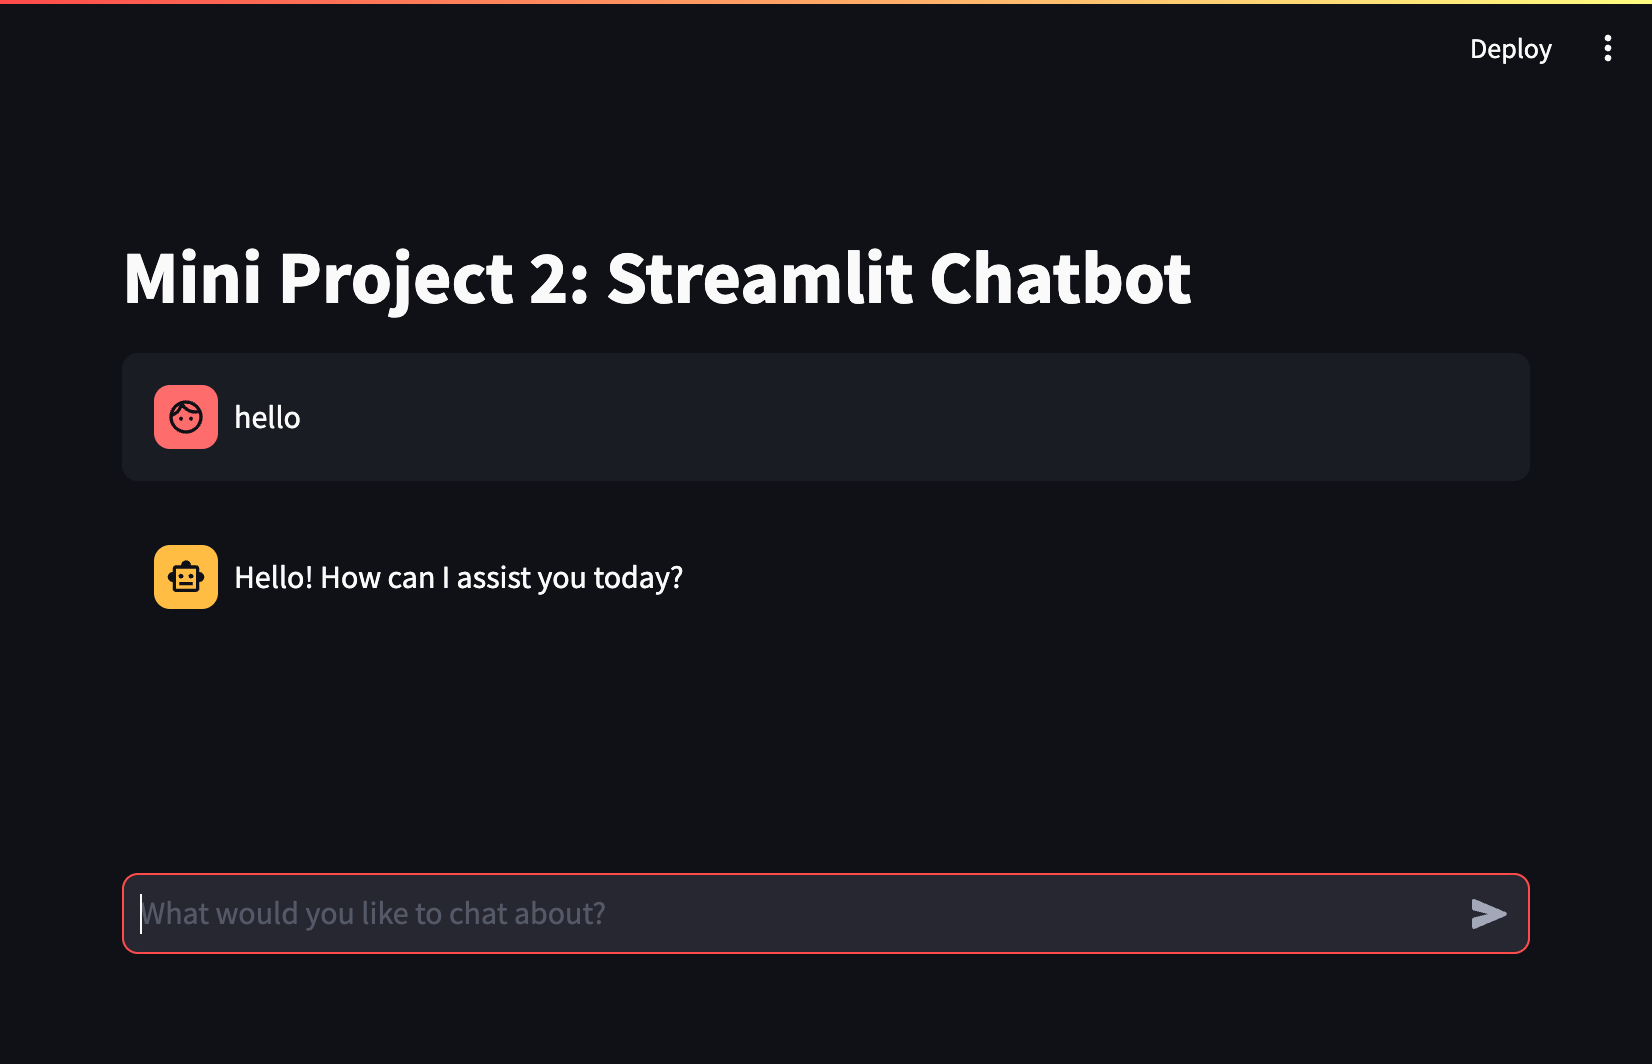

# Obstacles and more

Most of the tasks are not espacially difficult to handle by themsleves but when put together there were a few things that I needed to change. Since I need multi-conversation support, I need the relevant check to be done on all queries. Which lead to me having to delete irrelevant queries because otherwise a previous irrelevant query could make a later relevant query be seen as irrelevant. 

There was also the issue of finding what is a good similarity score for a relevant query. I found 80% to work well when testing. Using the 600 chunck size vs default(about 4000) and using "what is the capital of Spain?" and "what is principal component analysis?" as test, I got 6% similarity difference with default but 11% with 600 so that indicates that 600 is much more robust in classifying relevant and irrelevant queries.

When answering a relevant query, I force Chat-GPT to answer only using the relevant documents that I got from Pinecone.